# Анализ и результаты тестирования на IAM

In [1]:
import copy
import cv2
import Levenshtein
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pathlib
import random
import seaborn as sns

from collections import Counter

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

%cd /home/astrashnov/vedastr/

/home/astrashnov/vedastr


## Анализ датасетов

Посмотрим сначала на распределение символов в обучающем и тестовом датасетах:

In [2]:
def show_dir_info(input_dir):
    filenames = os.listdir(path=input_dir)
    dict_set = set()
    max_len = 0
    char_counter = Counter()
    for filename in filenames:
        label = filename.split('_')[0]
        dict_set = dict_set | set(label)
        max_len = max(max_len, len(label))
        char_counter = char_counter + Counter(label)
    dict_list = list(dict_set)
    print('Word number: {}'.format(len(filenames)))
    print('Max word length: ' + str(max_len))
    print('Alphabet size: ' + str(len(dict_list)))
    print('Dictionary: ' + ''.join(sorted(dict_list)))
    
    sorted_dict = sorted(dict(char_counter).items(), key=lambda kv: kv[1])
    keys = list(s[0] for s in sorted_dict)
    values = list(s[1] for s in sorted_dict)

    plt.figure(figsize=(12, 20))
    g = sns.barplot(y=keys, x=values)
    for i, value in enumerate(values):
        g.text(value, i, value, color='black', va='center')
    plt.title('Количество каждого символа в обучающем датасете')
    plt.xlabel('Количество в датасете')
    plt.ylabel('Символ')
    plt.show()

##### Обучающий датасет:

Word number: 60766
Max word length: 21
Alphabet size: 65
Dictionary: '-.0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz


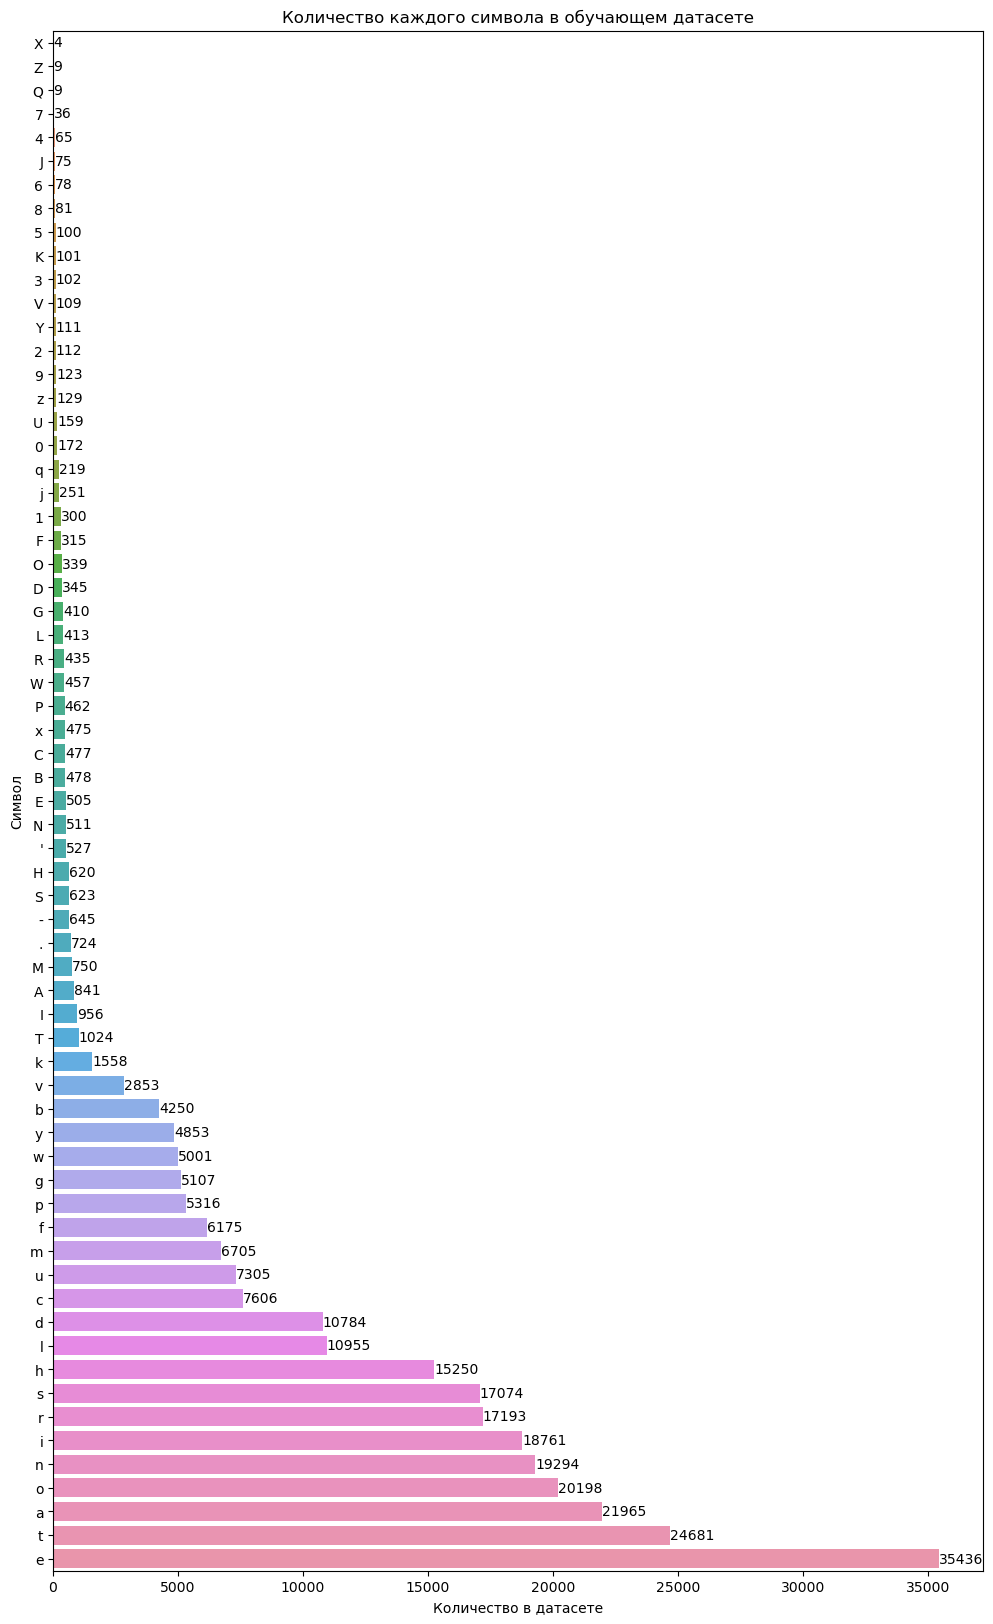

In [3]:
show_dir_info('/home/astrashnov/data/iam_data/train_words')

##### Тестовый датасет:

Word number: 17755
Max word length: 21
Alphabet size: 63
Dictionary: '-.0123456789ABCDEFGHIJKLMNOPQRSTUVWYabcdefghijklmnopqrstuvwxyz


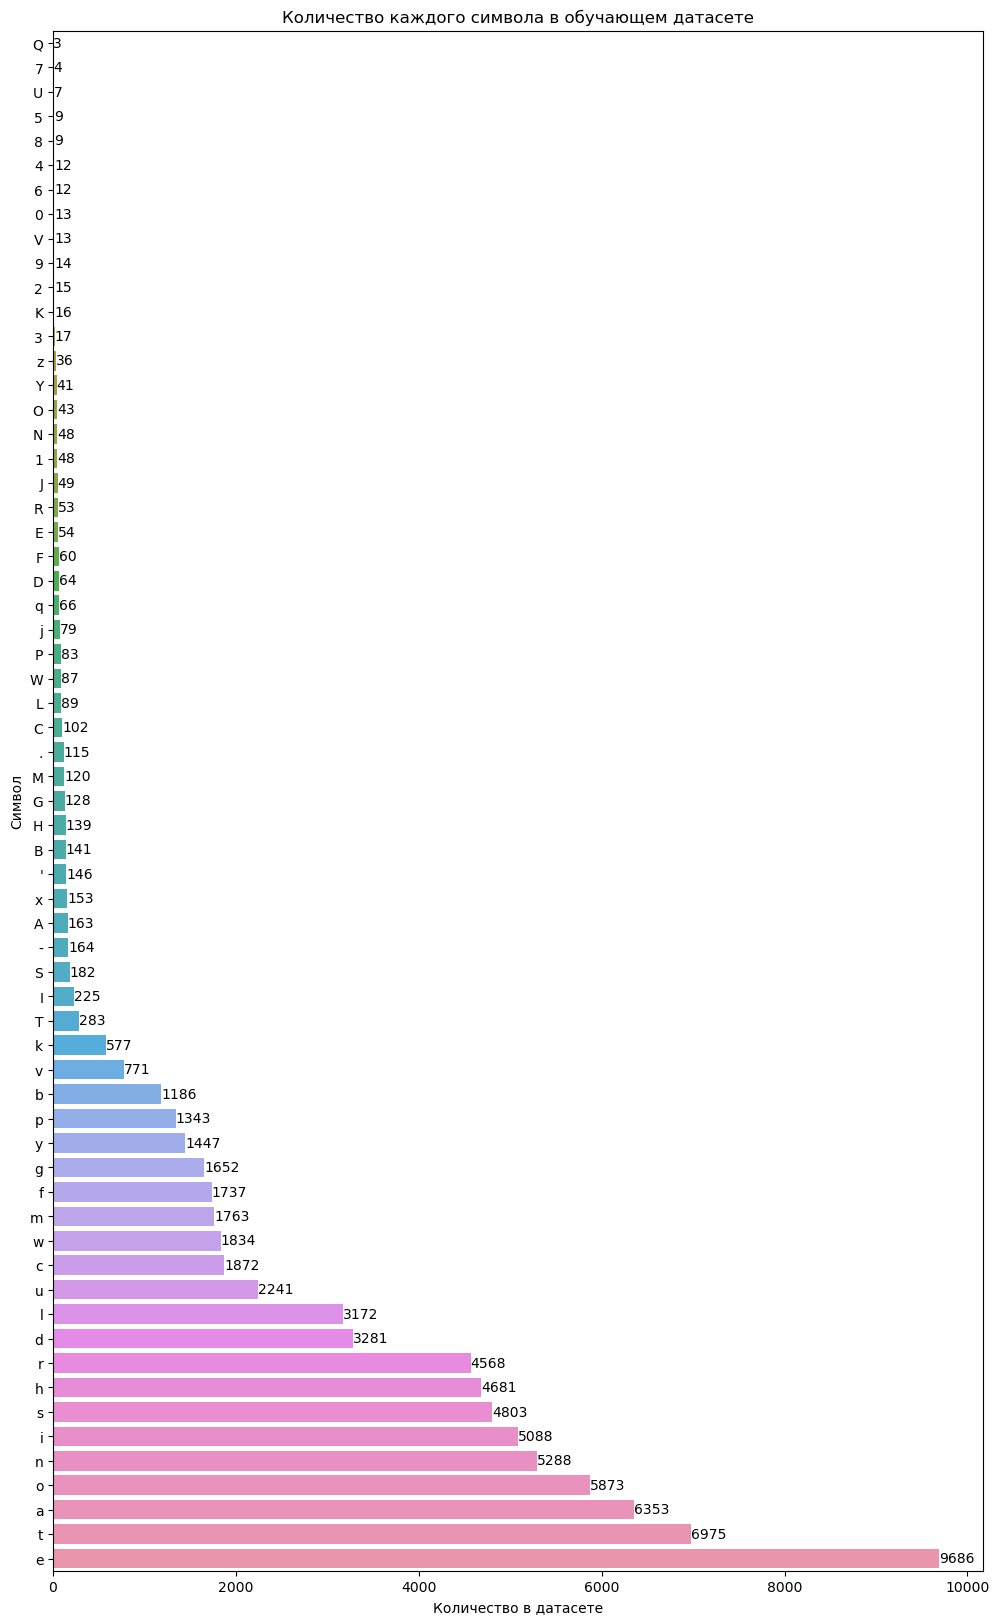

In [4]:
show_dir_info('/home/astrashnov/data/iam_data/test_words')

Видно, что распределения символов в обучающем и тестовом датасетах похожи.

Посмотрим теперь на некотрые изображения из обучающего датасета:

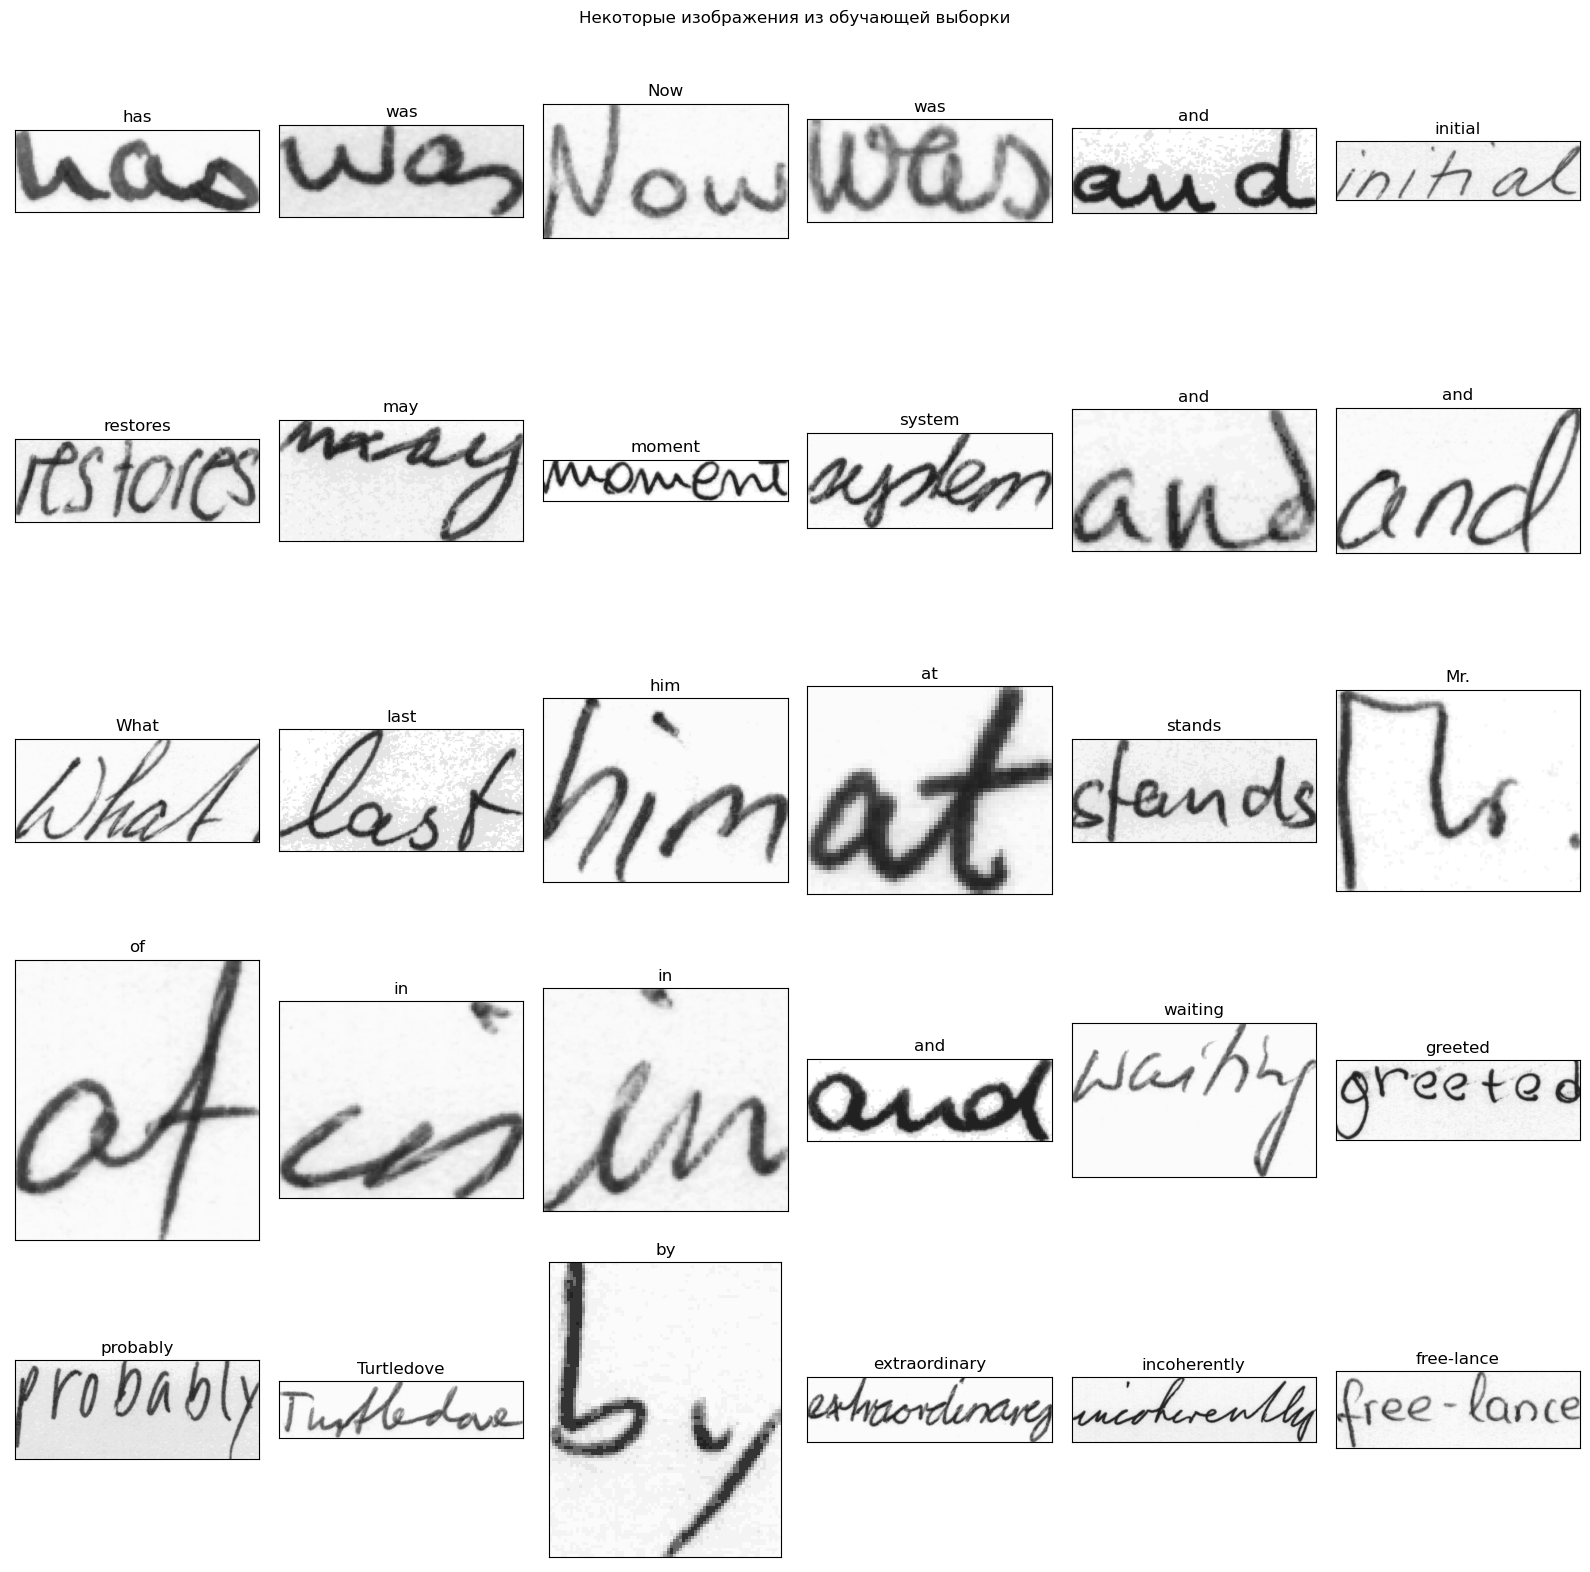

In [5]:
train_dir = '/home/astrashnov/data/iam_data/train_words'
imgs = os.listdir(train_dir)
imgs = random.choices(imgs, k=30)

plt.figure(figsize=(16, 16))
for i, img in enumerate(imgs):
    label = img.split('_')[0]
    image = cv2.imread(os.path.join(train_dir, img))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.subplot(5, 6, i + 1)
    plt.imshow(image)
    plt.title(label)
    plt.xticks([], [])
    plt.yticks([], [])
plt.suptitle('Некоторые изображения из обучающей выборки')
plt.tight_layout()
plt.show()

## Тестирование моделей

In [6]:
def get_dict(filename, alphabet="'-.0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ"):
    with open(filename) as f:
        lines = f.readlines()
    word_dict = {}
    for line in lines:
        l = line.strip('\n')
        if len(l) == 0:
            continue
        try:
            img_path, label = l.split()[:2]
        except:
            img_path, label = l.strip(), ''
        if not set(label.lower()).issubset(alphabet):
            continue
        word_dict[pathlib.PurePath(img_path).name] = label
    return word_dict

In [7]:
def general_stat(predictions_file, target_file, long_word_min_len=10, alphabet="'-.0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ"):
    pred_dict = get_dict(predictions_file, alphabet)
    target_dict = get_dict(target_file, alphabet)

    cases = ('LC + UC, all words', 'LC + UC, long words', 'LC + UC, short words',
             'MC, all words', 'MC, long words', 'MC, short words')
    if alphabet == alphabet.lower():
        cases = cases[3:]
        
    correct_num = {case: 0 for case in cases}
    edit_dis = {case: 0.0 for case in cases}
    norm_edit_dis = {case: 0.0 for case in cases}
    long_num = 0
    short_num = 0
    all_num = 0
    long_char = 0
    short_char = 0
    all_char = 0

    for name, target in target_dict.items():
        try:
            pred = pred_dict[name]
        except KeyError:
            print(name + " isn't predicted")
            continue
        pred_target = {'MC': (pred.lower(), target.lower())}
        if alphabet != alphabet.lower():
            pred_target['LC + UC'] = (pred, target)

        is_long = (len(target) >= long_word_min_len)

        for case, (pred, target) in pred_target.items():
            cur_edit_dis = Levenshtein.distance(pred, target)
            is_correct = int(pred == target)

            correct_num[case + ', all words'] += is_correct
            edit_dis[case + ', all words'] += cur_edit_dis
            norm_edit_dis[case + ', all words'] += cur_edit_dis / len(target)
            
            suf = ', short words'
            if is_long:
                suf = ', long words'
            correct_num[case + suf] += is_correct
            edit_dis[case + suf] += cur_edit_dis
            norm_edit_dis[case + suf] += cur_edit_dis / len(target)

        all_char += len(target)
        all_num += 1

        if is_long:
            long_char += len(target)
            long_num += 1
        else:
            short_char += len(target)
            short_num += 1
            
    case_function = lambda case, all_, short, long: max(all_ if (case[-9:-6] == 'all') else (long if (case[-10:-6] == 'long') else short), 1)
    acc = {'Accuracy ({})'.format(case): 1.0 * correct_num / case_function(case, all_num, short_num, long_num)
            for case, correct_num in correct_num.items()}
    norm_edit_dis = {'Normalized edit distance 1 ({})'.format(case): dis / case_function(case, all_num, short_num, long_num)
            for case, dis in norm_edit_dis.items()}
    edit_dis = {'Normalized edit distance 2 ({})'.format(case): dis / case_function(case, all_char, short_char, long_char)
            for case, dis in edit_dis.items()}
    quality_dict = dict(**acc, **norm_edit_dis, **edit_dis)

    for key, value in quality_dict.items():
        print(f'{key}: {value}')

In [8]:
def detailed_stat(predictions_file, target_file, long_word_min_len=10, alphabet="'-.0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ"):
    pred_dict = get_dict(predictions_file, alphabet)
    target_dict = get_dict(target_file, alphabet)
    lower_alphabet = ''.join(set(alphabet.lower()))

    cases = ('LC + UC, all words', 'LC + UC, long words', 'MC, all words', 'MC, long words')
    matrix1 = {'del': {char: 0 for char in alphabet}, 'ins': {char: 0 for char in alphabet}}
    matrix1 = dict(**matrix1, **{sym: {char: 0 for char in alphabet} for sym in alphabet})
    matrix2 = {'del': {char: 0 for char in lower_alphabet}, 'ins': {char: 0 for char in lower_alphabet}}
    matrix2 = dict(**matrix2, **{sym: {char: 0 for char in lower_alphabet} for sym in lower_alphabet})
    matrices = {case: copy.deepcopy(matrix1) if case[0] == 'L' else copy.deepcopy(matrix2) for case in cases}
    
    if alphabet == alphabet.lower():
        cases = cases[2:]
    
    mistakes = []
    for name, target in target_dict.items():
        try:
            pred = pred_dict[name]
        except KeyError:
            print(name + " isn't predicted")
            continue
        pred_target = {'MC': (pred.lower(), target.lower())}
        if alphabet != alphabet.lower():
            pred_target['LC + UC'] = (pred, target)
        else:
            pred, target = pred.lower(), target.lower()
        
        if target != pred:
            mistakes.append((pred, target, name))

        is_long = (len(target) >= long_word_min_len)

        for case, (pred, target) in pred_target.items():
            ops = Levenshtein.editops(pred, target)
            matrices_names = [case + ', all words',]
            if is_long:
                matrices_names.append(case + ', long words')
            for matrix_name in matrices_names:
                for op in ops:
                    if op[0] == 'insert':
                        matrices[matrix_name]['ins'][target[op[2]]] += 1
                    elif op[0] == 'delete':
                        matrices[matrix_name]['del'][pred[op[1]]] += 1
                    elif op[0] == 'replace':
                        matrices[matrix_name][pred[op[1]]][target[op[2]]] += 1
                        
    tables = {}
    for case in cases:
        tables[case] = pd.DataFrame.from_dict(matrices[case]).transpose()
        
    return tables, mistakes

### Модель, обученная на словаре LC + UC + Num + Pc3

Получим предсказания обученной модели, а также правильные метки:

In [9]:
pred_file = '/home/astrashnov/vedastr/workdir/predictions_cstr_original_LC_UC_Num_Pc3.txt'
target_file = '/home/astrashnov/data/iam_data/rec_test.txt'

##### Качество модели:

In [10]:
general_stat(pred_file, target_file)

Accuracy (LC + UC, all words): 0.789974655026753
Accuracy (LC + UC, long words): 0.2706552706552707
Accuracy (LC + UC, short words): 0.811352841142321
Accuracy (MC, all words): 0.7993241340467474
Accuracy (MC, long words): 0.27350427350427353
Accuracy (MC, short words): 0.8209699173166012
Normalized edit distance 1 (LC + UC, all words): 0.07734677311752794
Normalized edit distance 1 (LC + UC, long words): 0.28449369764861565
Normalized edit distance 1 (LC + UC, short words): 0.06881940895750804
Normalized edit distance 1 (MC, all words): 0.07282969354201413
Normalized edit distance 1 (MC, long words): 0.282803015348959
Normalized edit distance 1 (MC, short words): 0.06418597854122408
Normalized edit distance 2 (LC + UC, all words): 0.10626008878127523
Normalized edit distance 2 (LC + UC, long words): 0.2961183954303518
Normalized edit distance 2 (LC + UC, short words): 0.08583241378347045
Normalized edit distance 2 (MC, all words): 0.10240112994350282
Normalized edit distance 2 (MC, lo

In [11]:
tables, mistakes = detailed_stat(pred_file, target_file)

Посмотрим на посимвольные таблицы ошибок для разных длин слов с учётом и без учёта регистра:

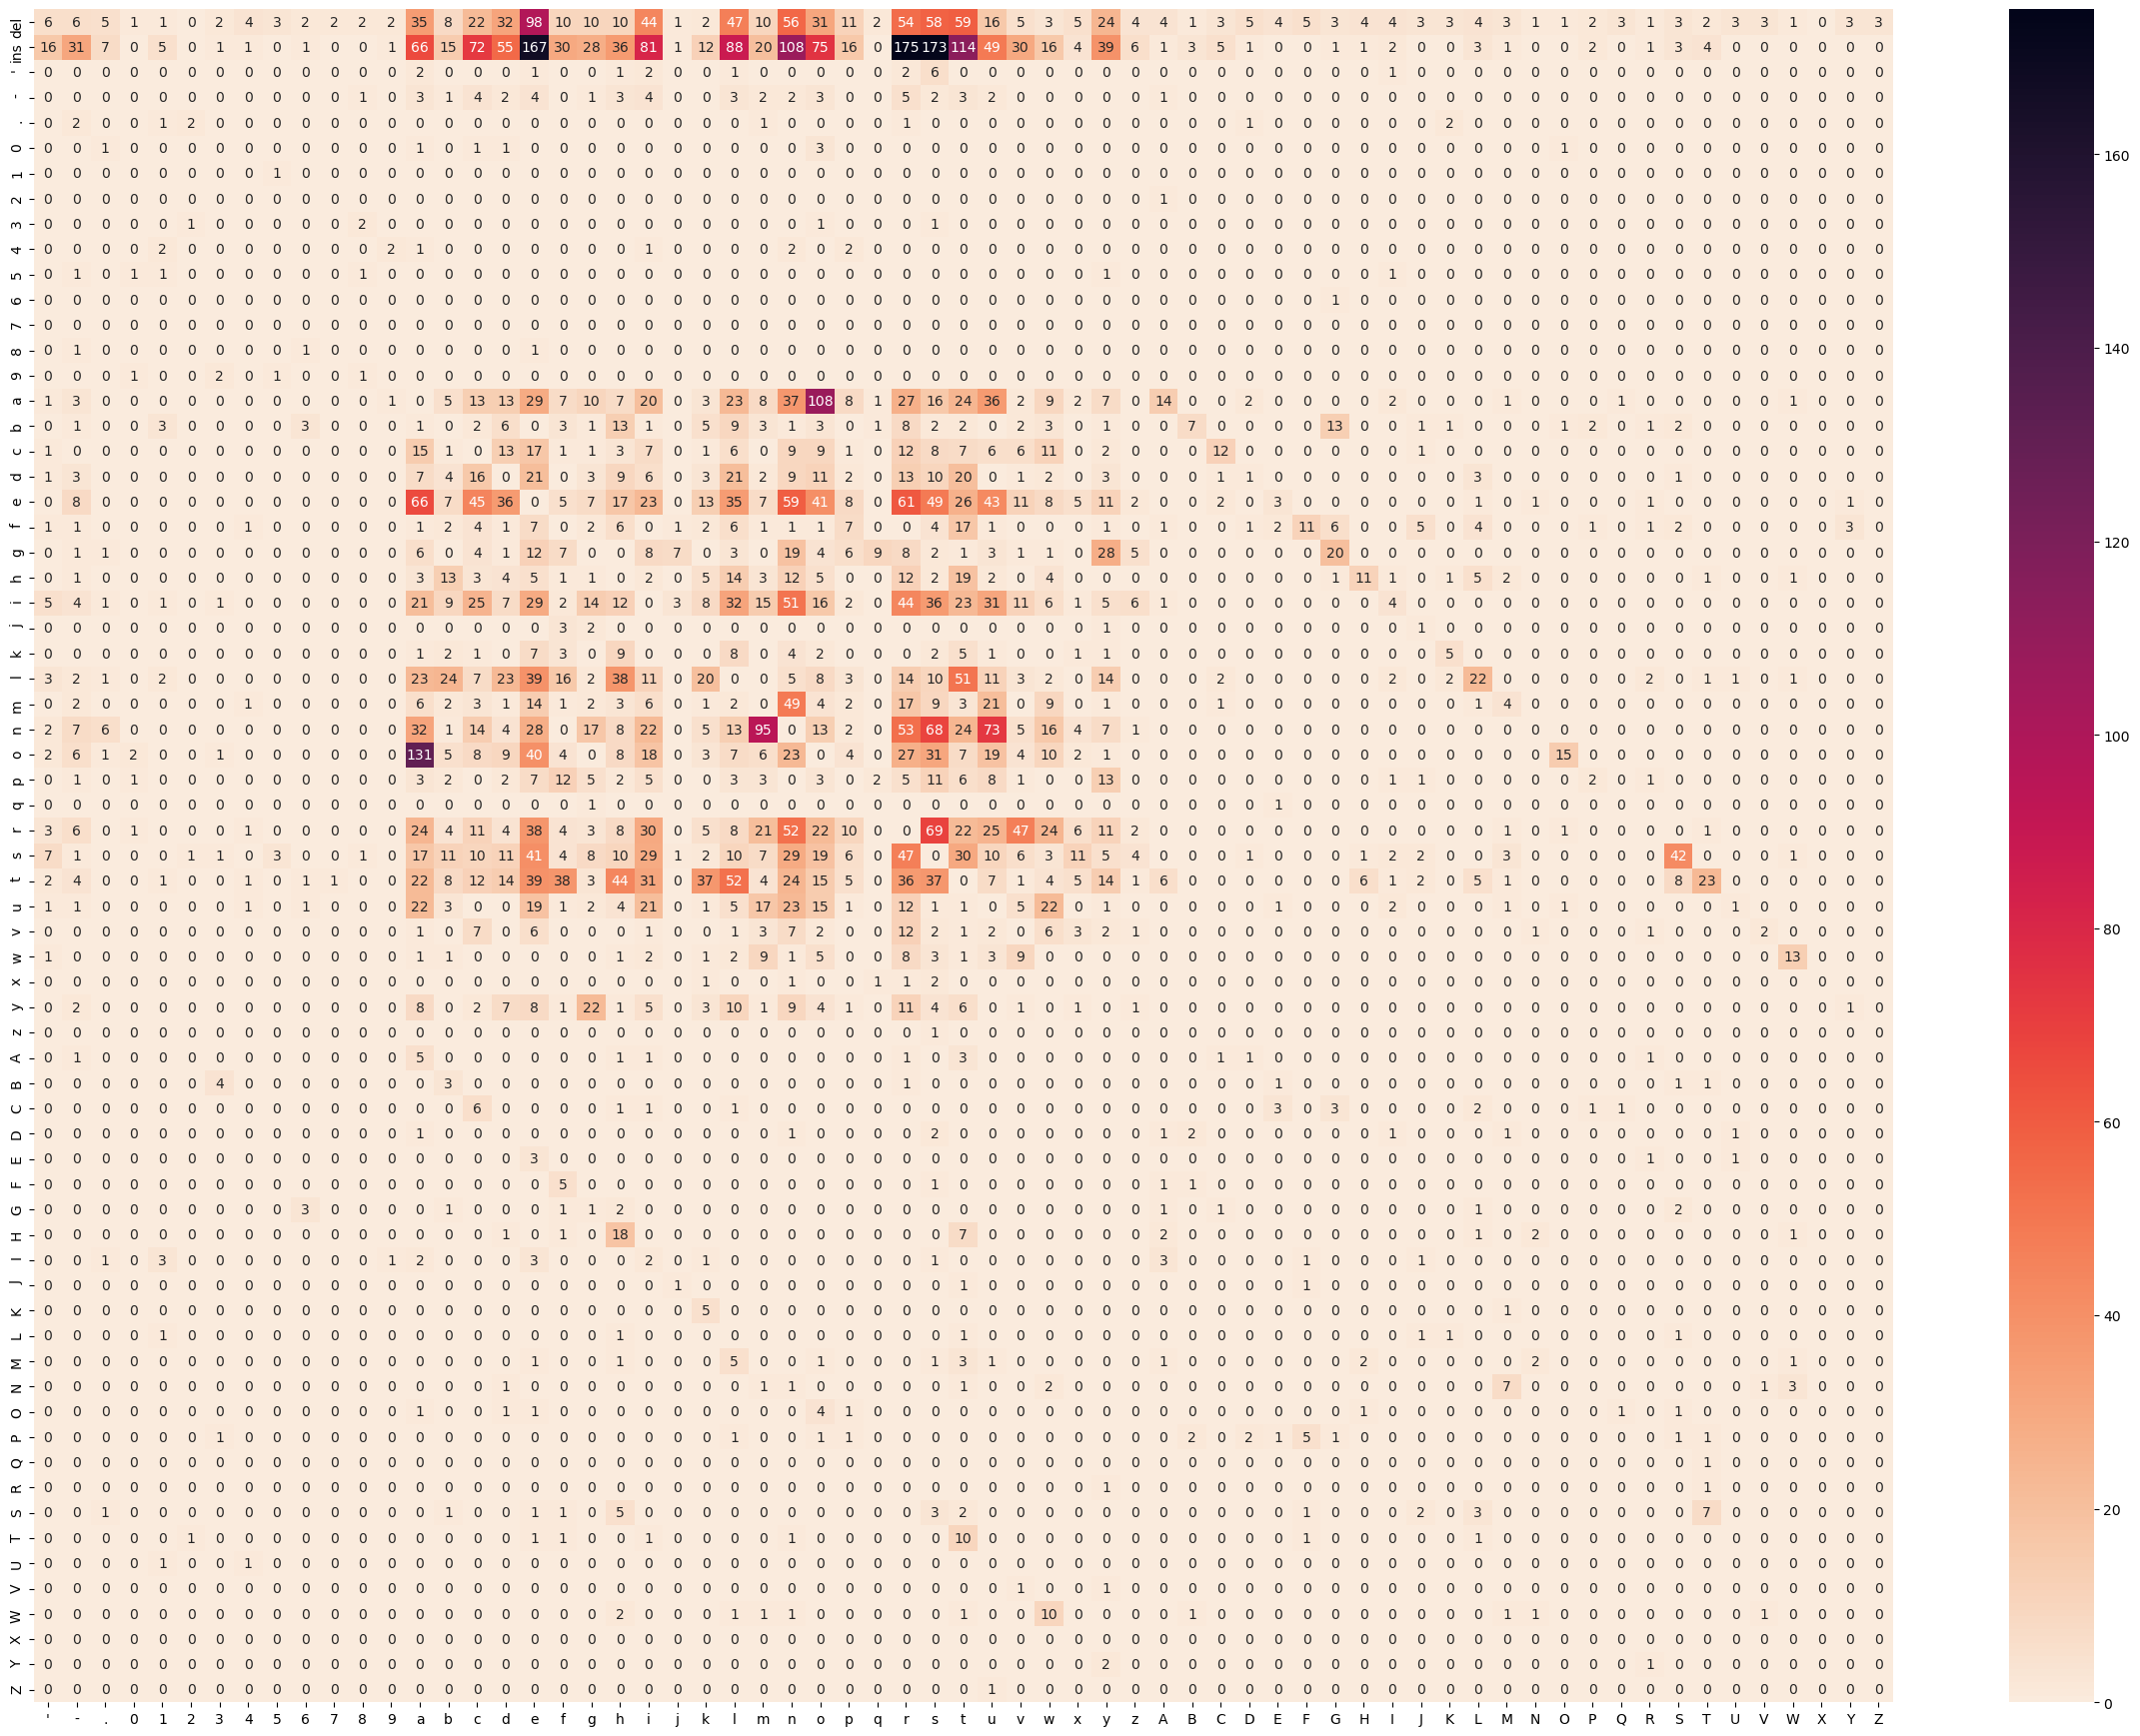

In [12]:
plt.figure(figsize=(30, 22))
sns.heatmap(tables['LC + UC, all words'], cmap='rocket_r', annot=True, fmt="d")
plt.show()

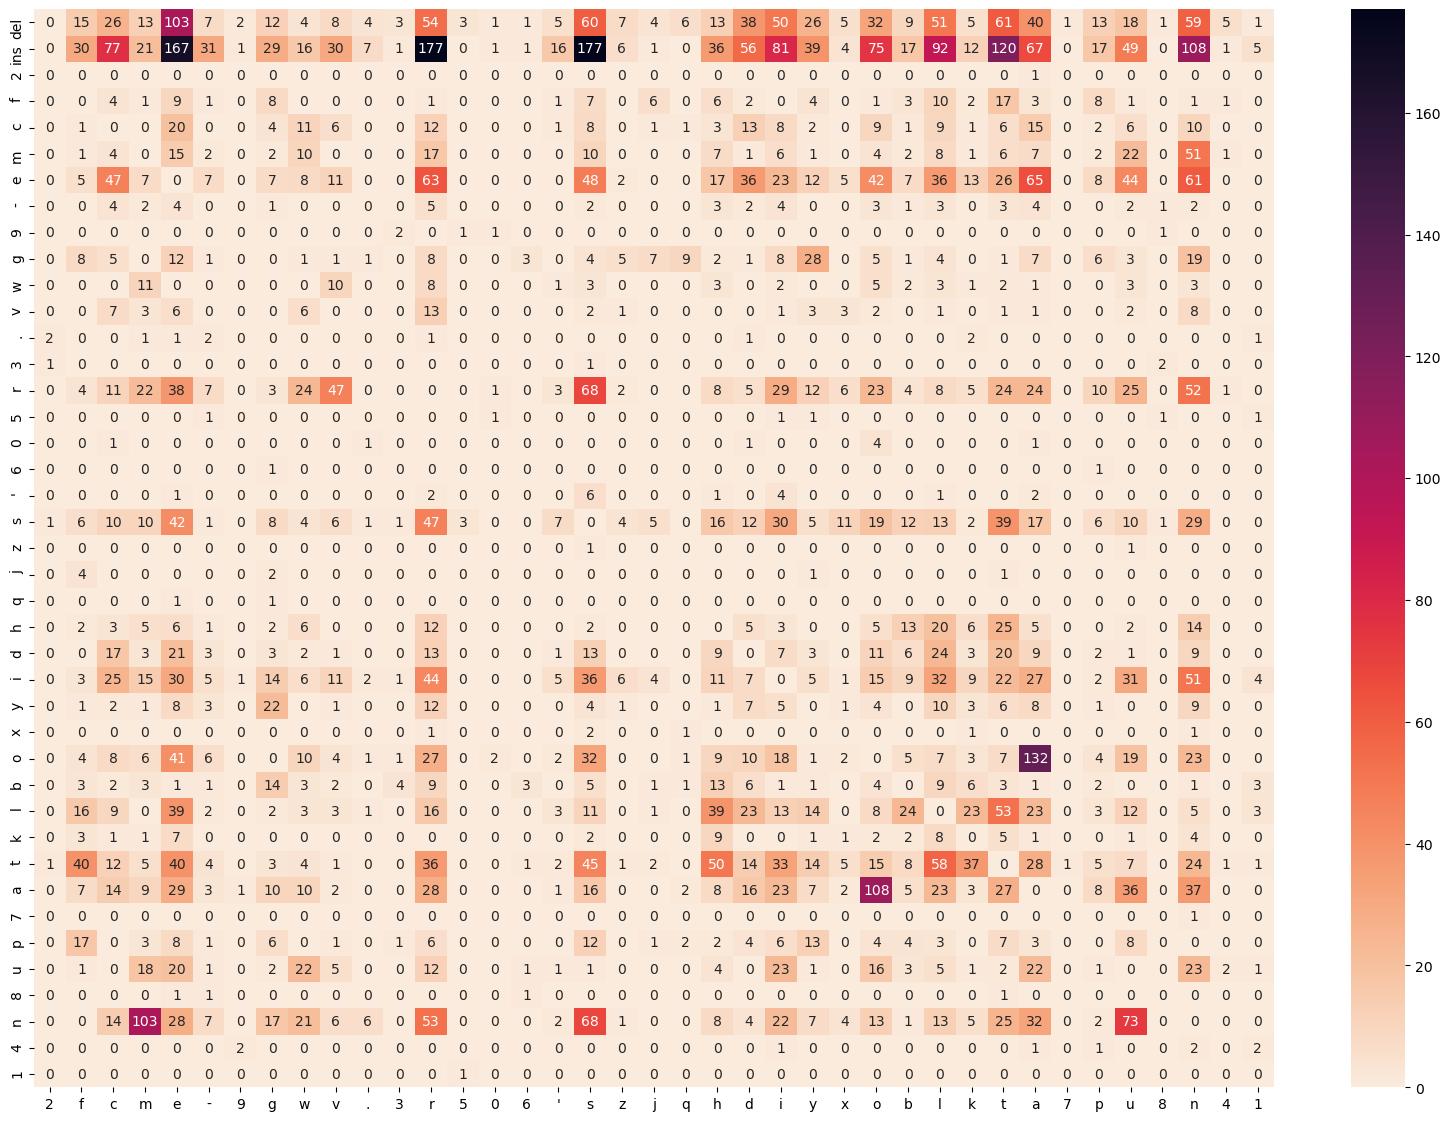

In [13]:
plt.figure(figsize=(20, 14))
sns.heatmap(tables['MC, all words'], cmap='rocket_r', annot=True, fmt="d")
plt.show()

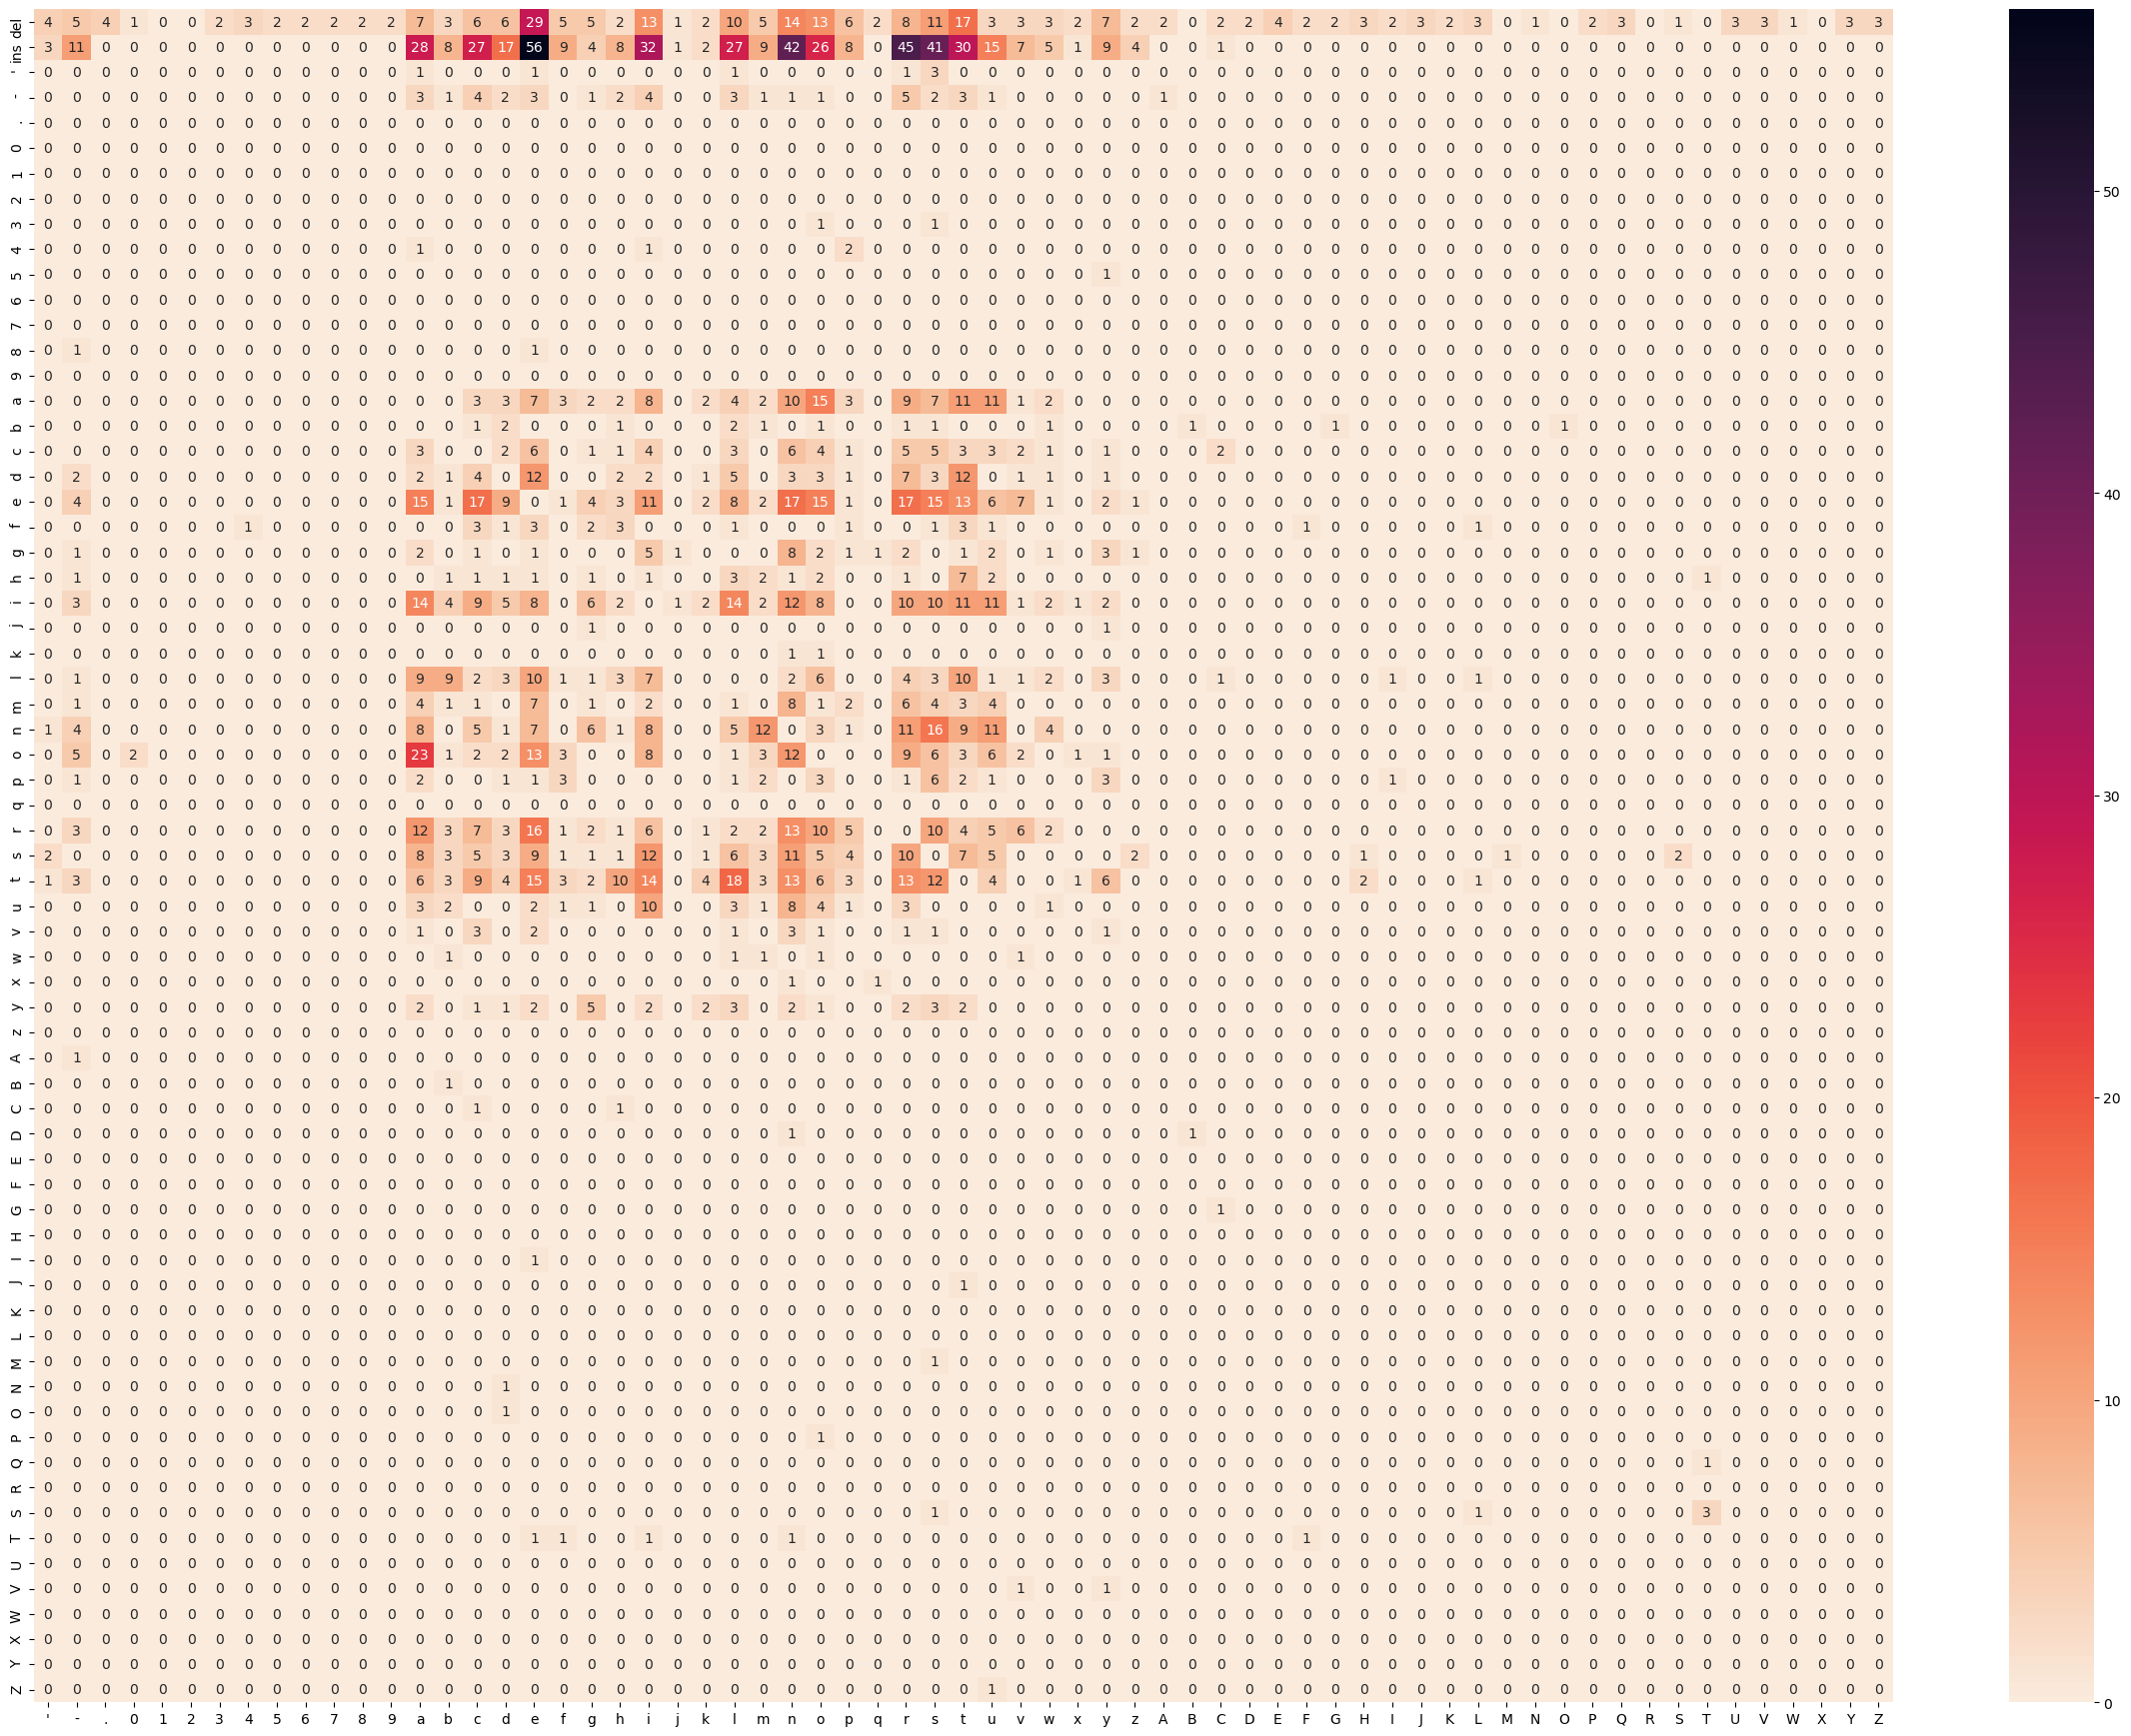

In [14]:
plt.figure(figsize=(30, 22))
sns.heatmap(tables['LC + UC, long words'], cmap='rocket_r', annot=True, fmt="d")
plt.show()

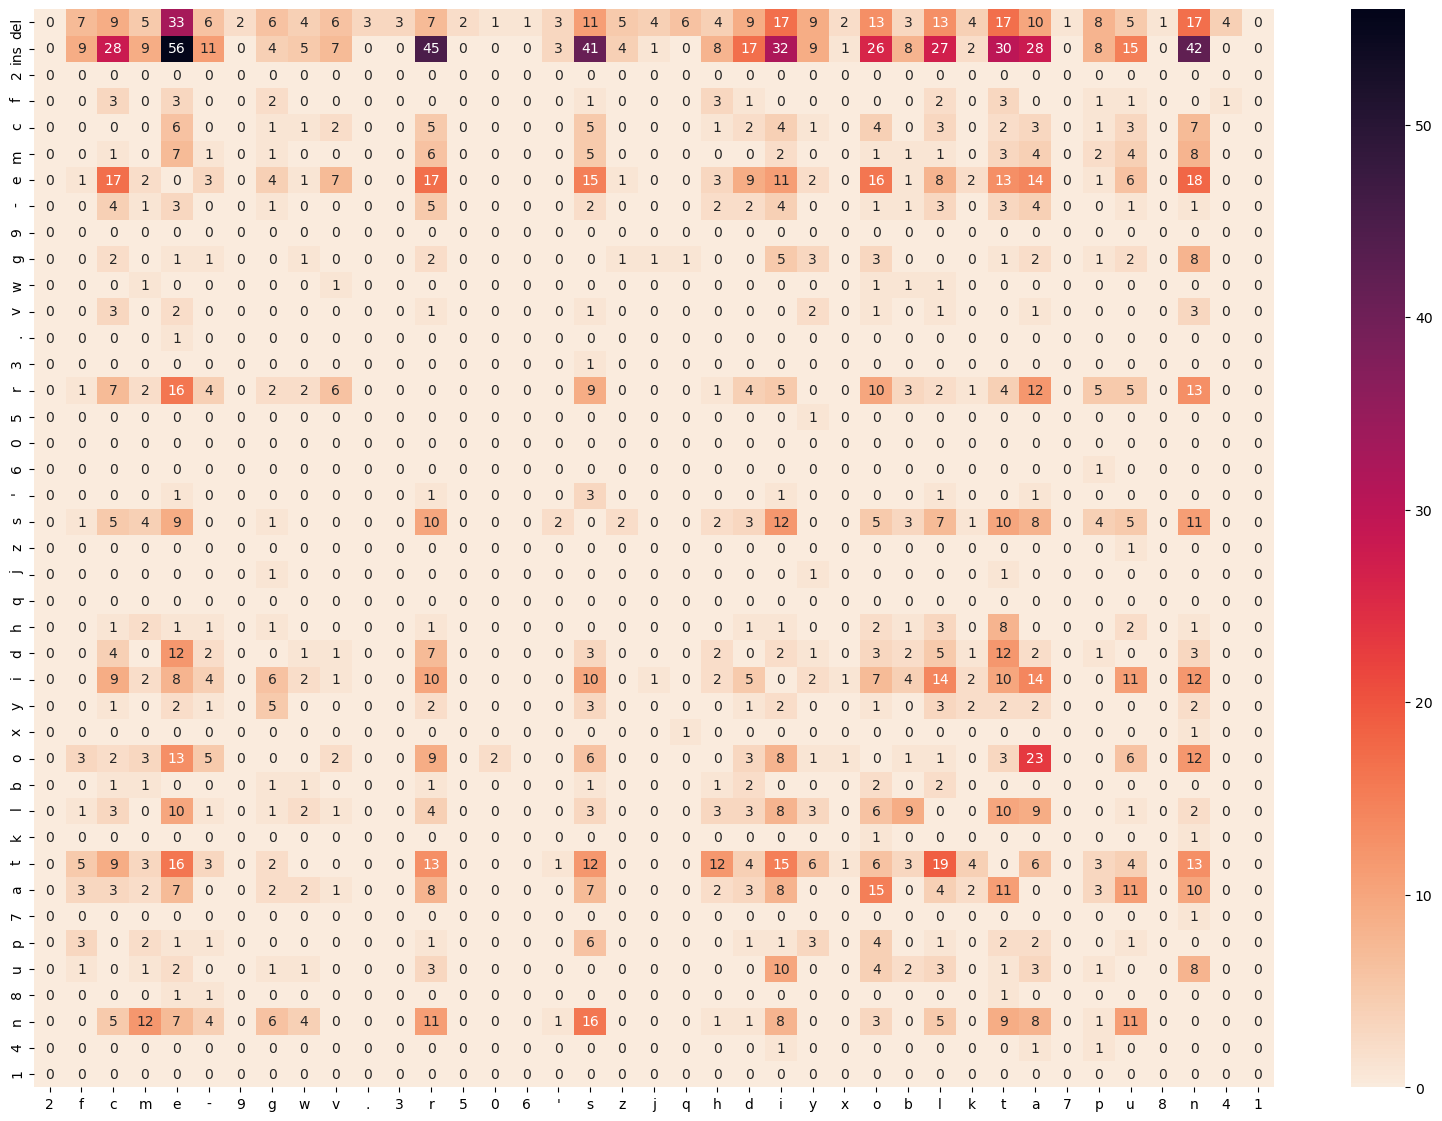

In [15]:
plt.figure(figsize=(20, 14))
sns.heatmap(tables['MC, long words'], cmap='rocket_r', annot=True, fmt="d")
plt.show()

Посмотрим на некоторые неправильно распознанные изображения:

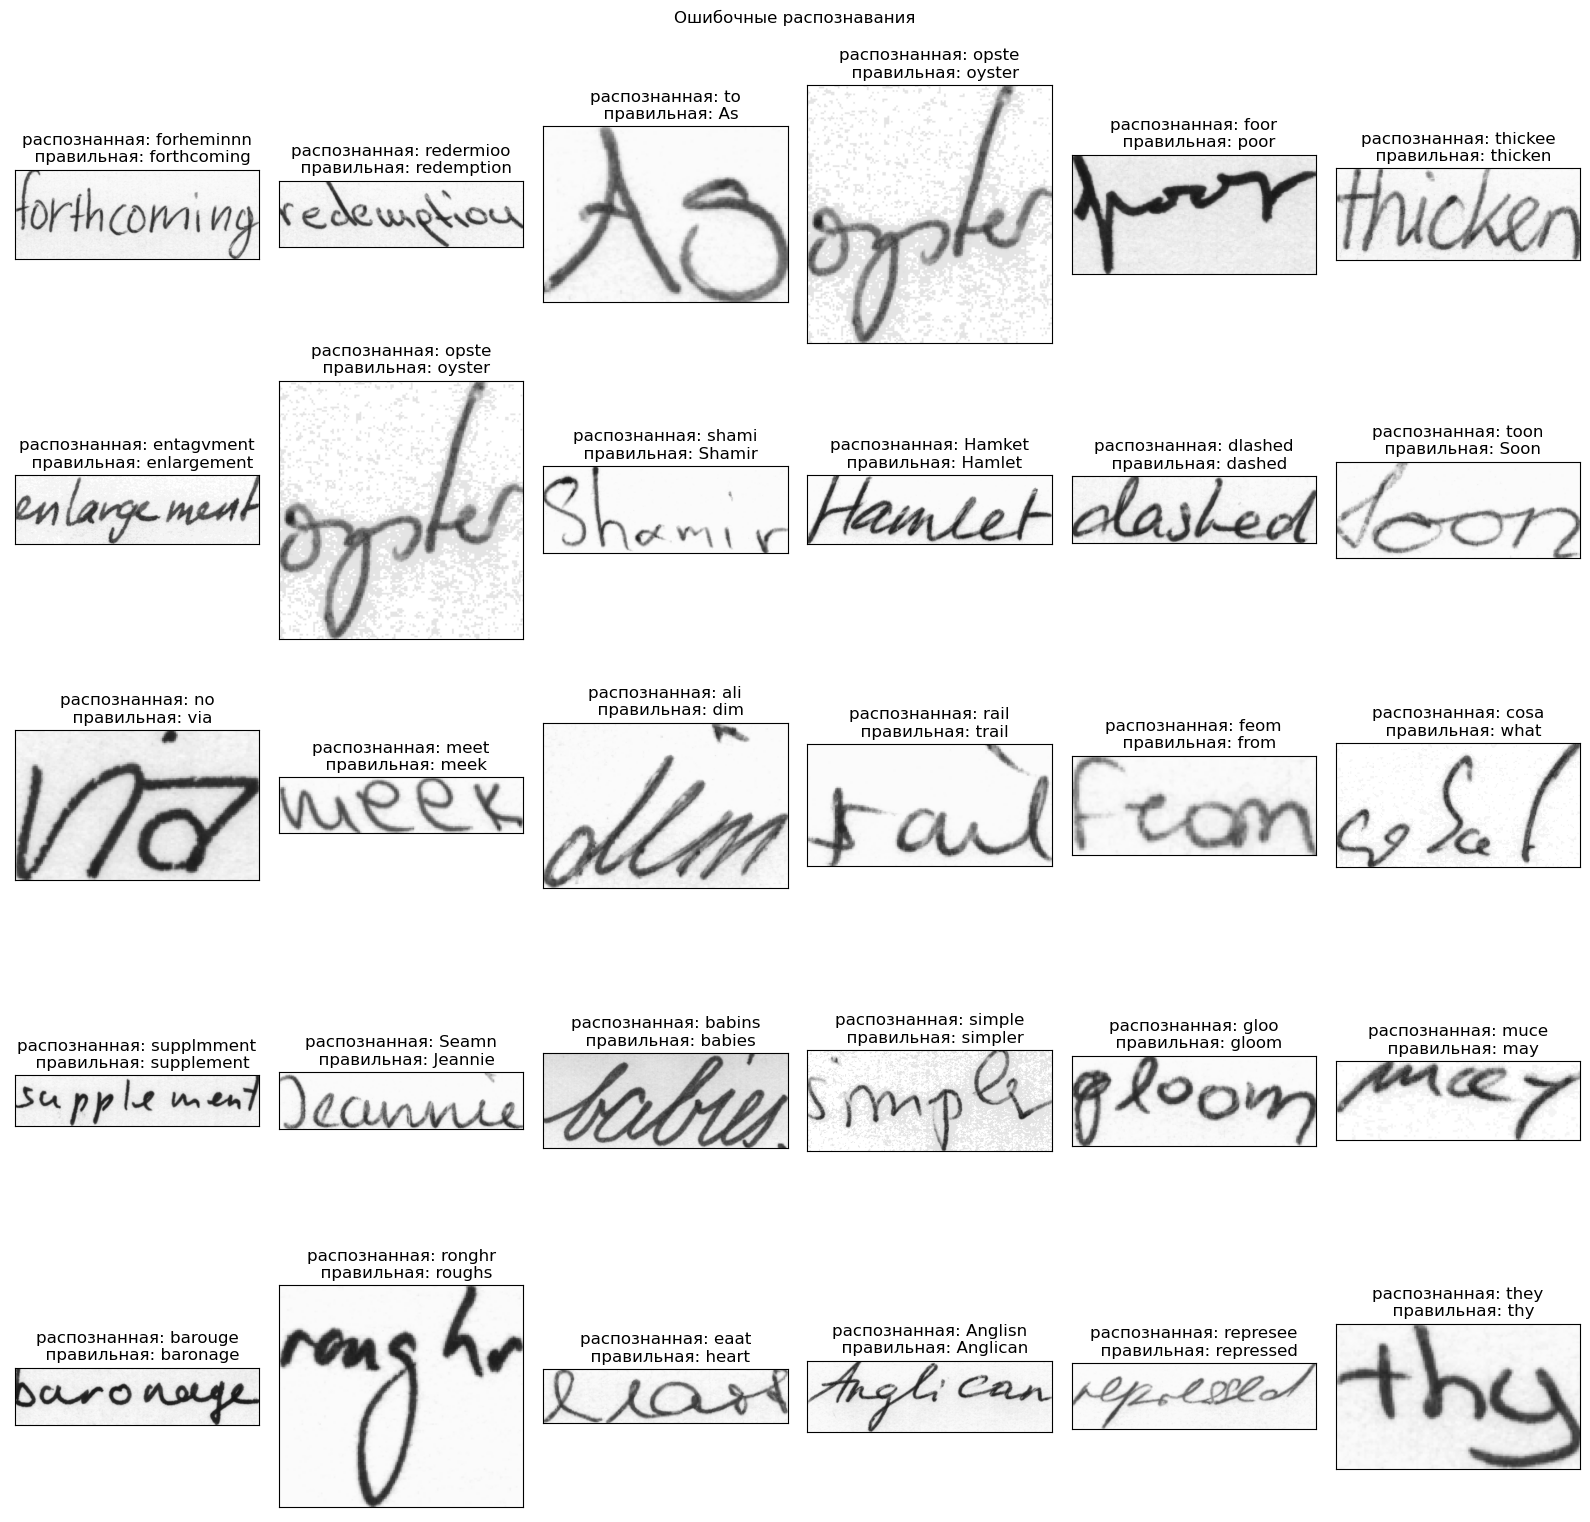

In [16]:
test_dir = '/home/astrashnov/data/iam_data/test_words'
some_mistakes = random.choices(mistakes, k = 30)

plt.figure(figsize=(16, 16))
for i, (pred, target, name) in enumerate(some_mistakes):
    image = cv2.imread(os.path.join(test_dir, name))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.subplot(5, 6, i + 1)
    plt.imshow(image)
    plt.title(f'распознанная: {pred}\n  правильная: {target}')
    plt.xticks([], [])
    plt.yticks([], [])
plt.suptitle('Ошибочные распознавания')
plt.tight_layout()
plt.show()

### Модель, обученная на словаре MC

Получим предсказания обученной модели, а также правильные метки:

In [17]:
pred_file = '/home/astrashnov/vedastr/workdir/predictions_cstr_original_MC.txt'
target_file = '/home/astrashnov/data/iam_data/rec_test.txt'

##### Качество модели:

In [18]:
general_stat(pred_file, target_file, alphabet="abcdefghijklmnopqrstuvwxyz")

Accuracy (MC, all words): 0.8252236652236652
Accuracy (MC, long words): 0.36482084690553745
Accuracy (MC, short words): 0.8421399078451319
Normalized edit distance 1 (MC, all words): 0.060605580006013016
Normalized edit distance 1 (MC, long words): 0.20308348681720034
Normalized edit distance 1 (MC, short words): 0.055370618915589344
Normalized edit distance 2 (MC, all words): 0.08140505569613649
Normalized edit distance 2 (MC, long words): 0.2069379786754768
Normalized edit distance 2 (MC, short words): 0.06946448212321625


In [19]:
tables, mistakes = detailed_stat(pred_file, target_file, alphabet="abcdefghijklmnopqrstuvwxyz")

Посмотрим на посимвольные таблицы ошибок для разных длин слов:

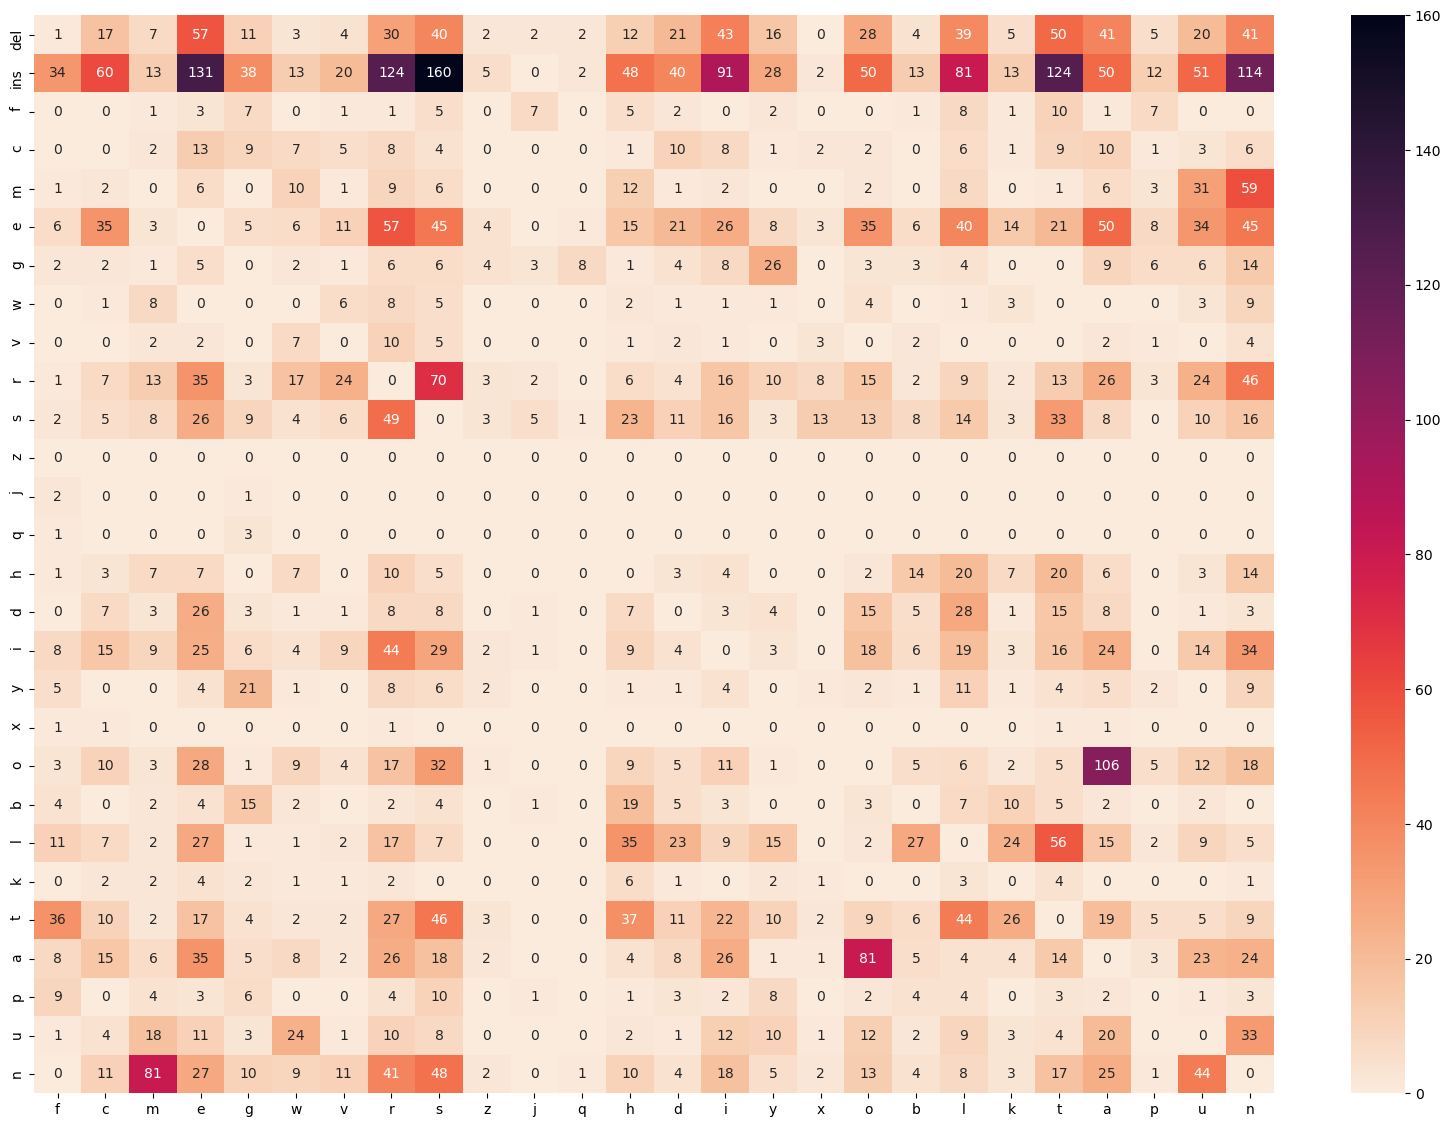

In [20]:
plt.figure(figsize=(20, 14))
sns.heatmap(tables['MC, all words'], cmap='rocket_r', annot=True, fmt="d")
plt.show()

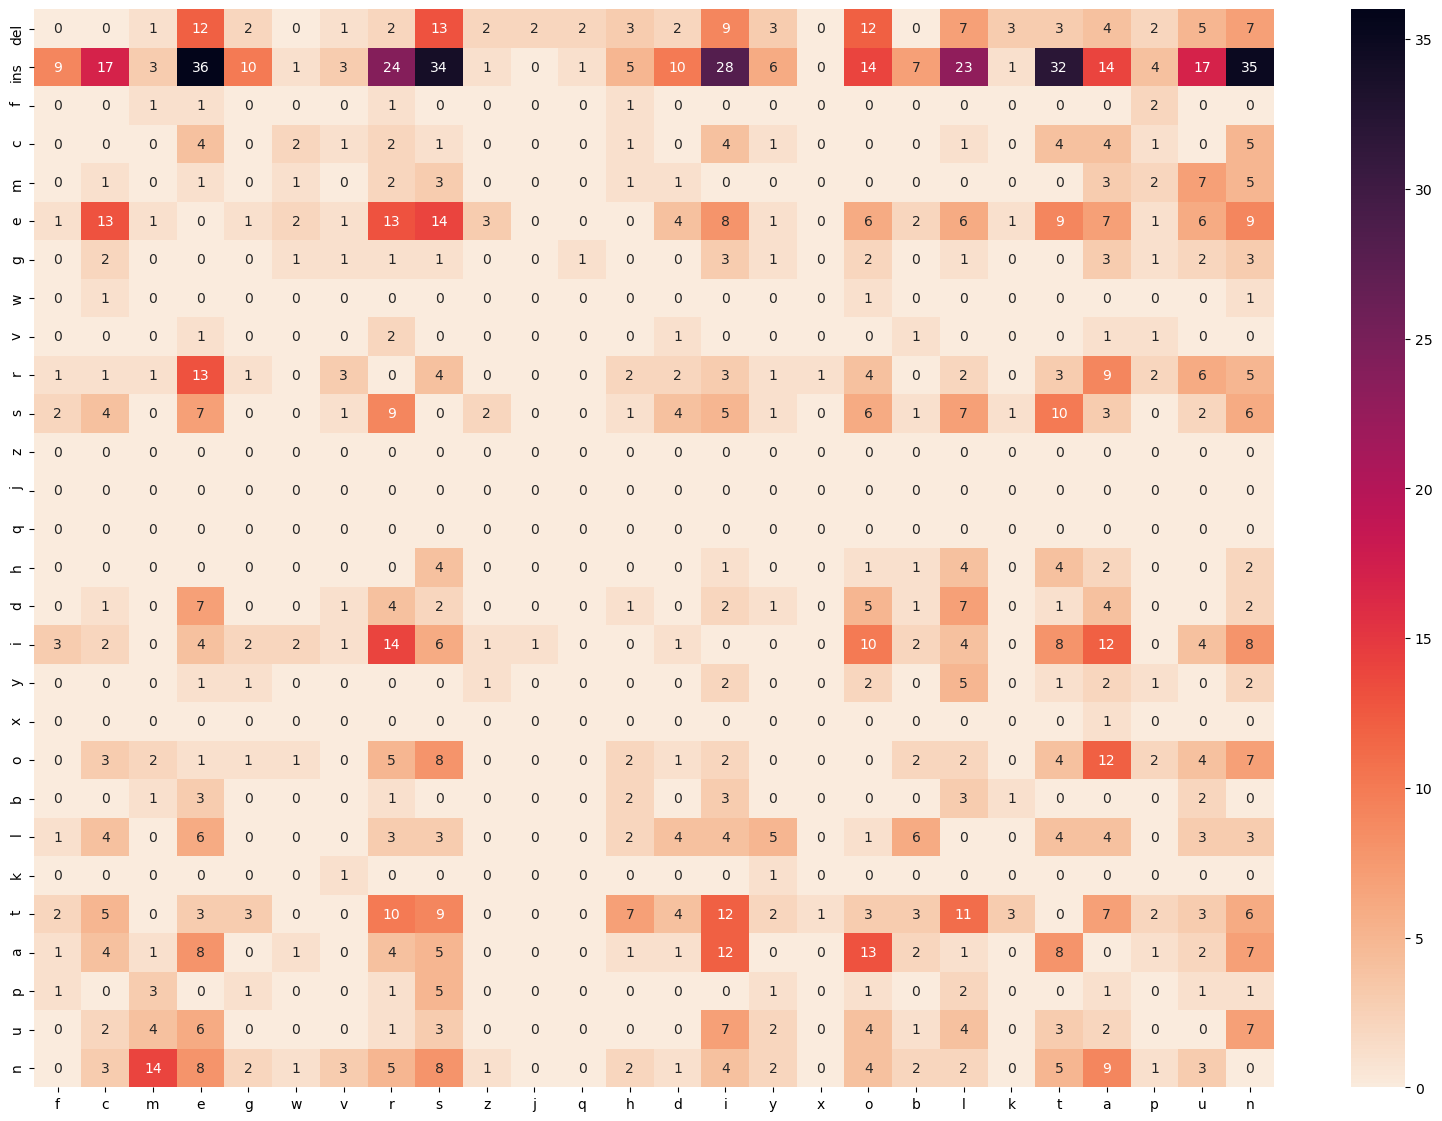

In [21]:
plt.figure(figsize=(20, 14))
sns.heatmap(tables['MC, long words'], cmap='rocket_r', annot=True, fmt="d")
plt.show()

Посмотрим на некоторые неправильно распознанные изображения:

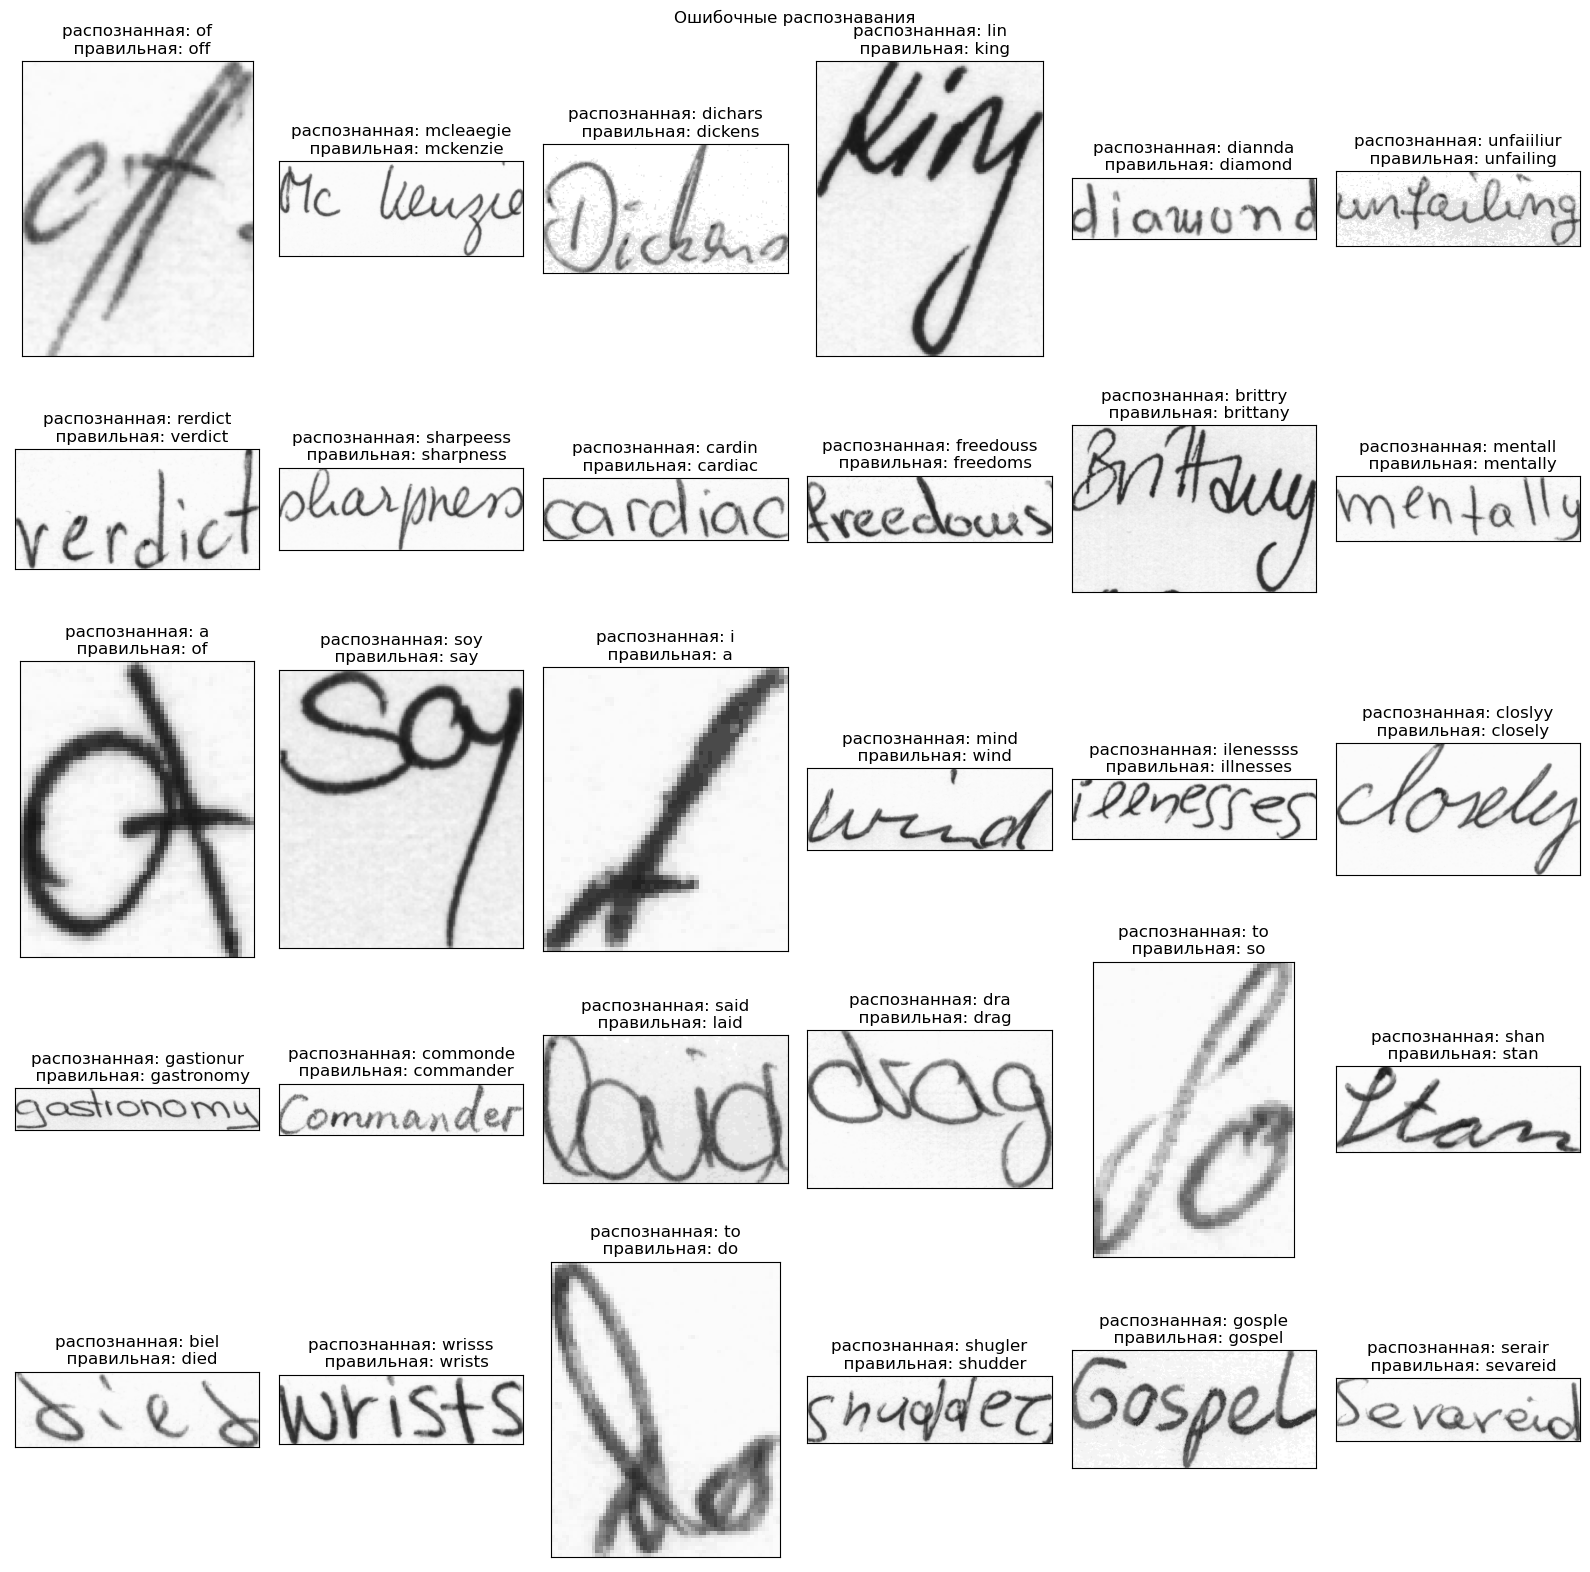

In [22]:
test_dir = '/home/astrashnov/data/iam_data/test_words'
some_mistakes = random.choices(mistakes, k = 30)

plt.figure(figsize=(16, 16))
for i, (pred, target, name) in enumerate(some_mistakes):
    image = cv2.imread(os.path.join(test_dir, name))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.subplot(5, 6, i + 1)
    plt.imshow(image)
    plt.title(f'распознанная: {pred}\n  правильная: {target}')
    plt.xticks([], [])
    plt.yticks([], [])
plt.suptitle('Ошибочные распознавания')
plt.tight_layout()
plt.show()

### Модель, предобученная на MJSynth + SynthText (словарь LC + UC + Num + Pc3):

Получим предсказания обученной модели, а также правильные метки:

In [23]:
pred_file = '/home/astrashnov/vedastr/workdir/predictions_cstr_MJSST+original_LC_UC_Num_Pc3.txt'
target_file = '/home/astrashnov/data/iam_data/rec_test.txt'

##### Качество модели:

In [24]:
general_stat(pred_file, target_file)

Accuracy (LC + UC, all words): 0.8695015488594762
Accuracy (LC + UC, long words): 0.6111111111111112
Accuracy (LC + UC, short words): 0.8801383920717762
Accuracy (MC, all words): 0.8795832159954943
Accuracy (MC, long words): 0.6153846153846154
Accuracy (MC, short words): 0.8904591567466135
Normalized edit distance 1 (LC + UC, all words): 0.041511579128857376
Normalized edit distance 1 (LC + UC, long words): 0.06986556569145692
Normalized edit distance 1 (LC + UC, short words): 0.04034436523294779
Normalized edit distance 1 (MC, all words): 0.037015718126378515
Normalized edit distance 1 (MC, long words): 0.06757872622513028
Normalized edit distance 1 (MC, short words): 0.03575756814189926
Normalized edit distance 2 (LC + UC, all words): 0.04749293785310735
Normalized edit distance 2 (LC + UC, long words): 0.07425678307153057
Normalized edit distance 2 (LC + UC, short words): 0.04461330018297878
Normalized edit distance 2 (MC, all words): 0.04357092413236481
Normalized edit distance 2 (

Посмотрим на некоторые неправильно распознанные изображения:

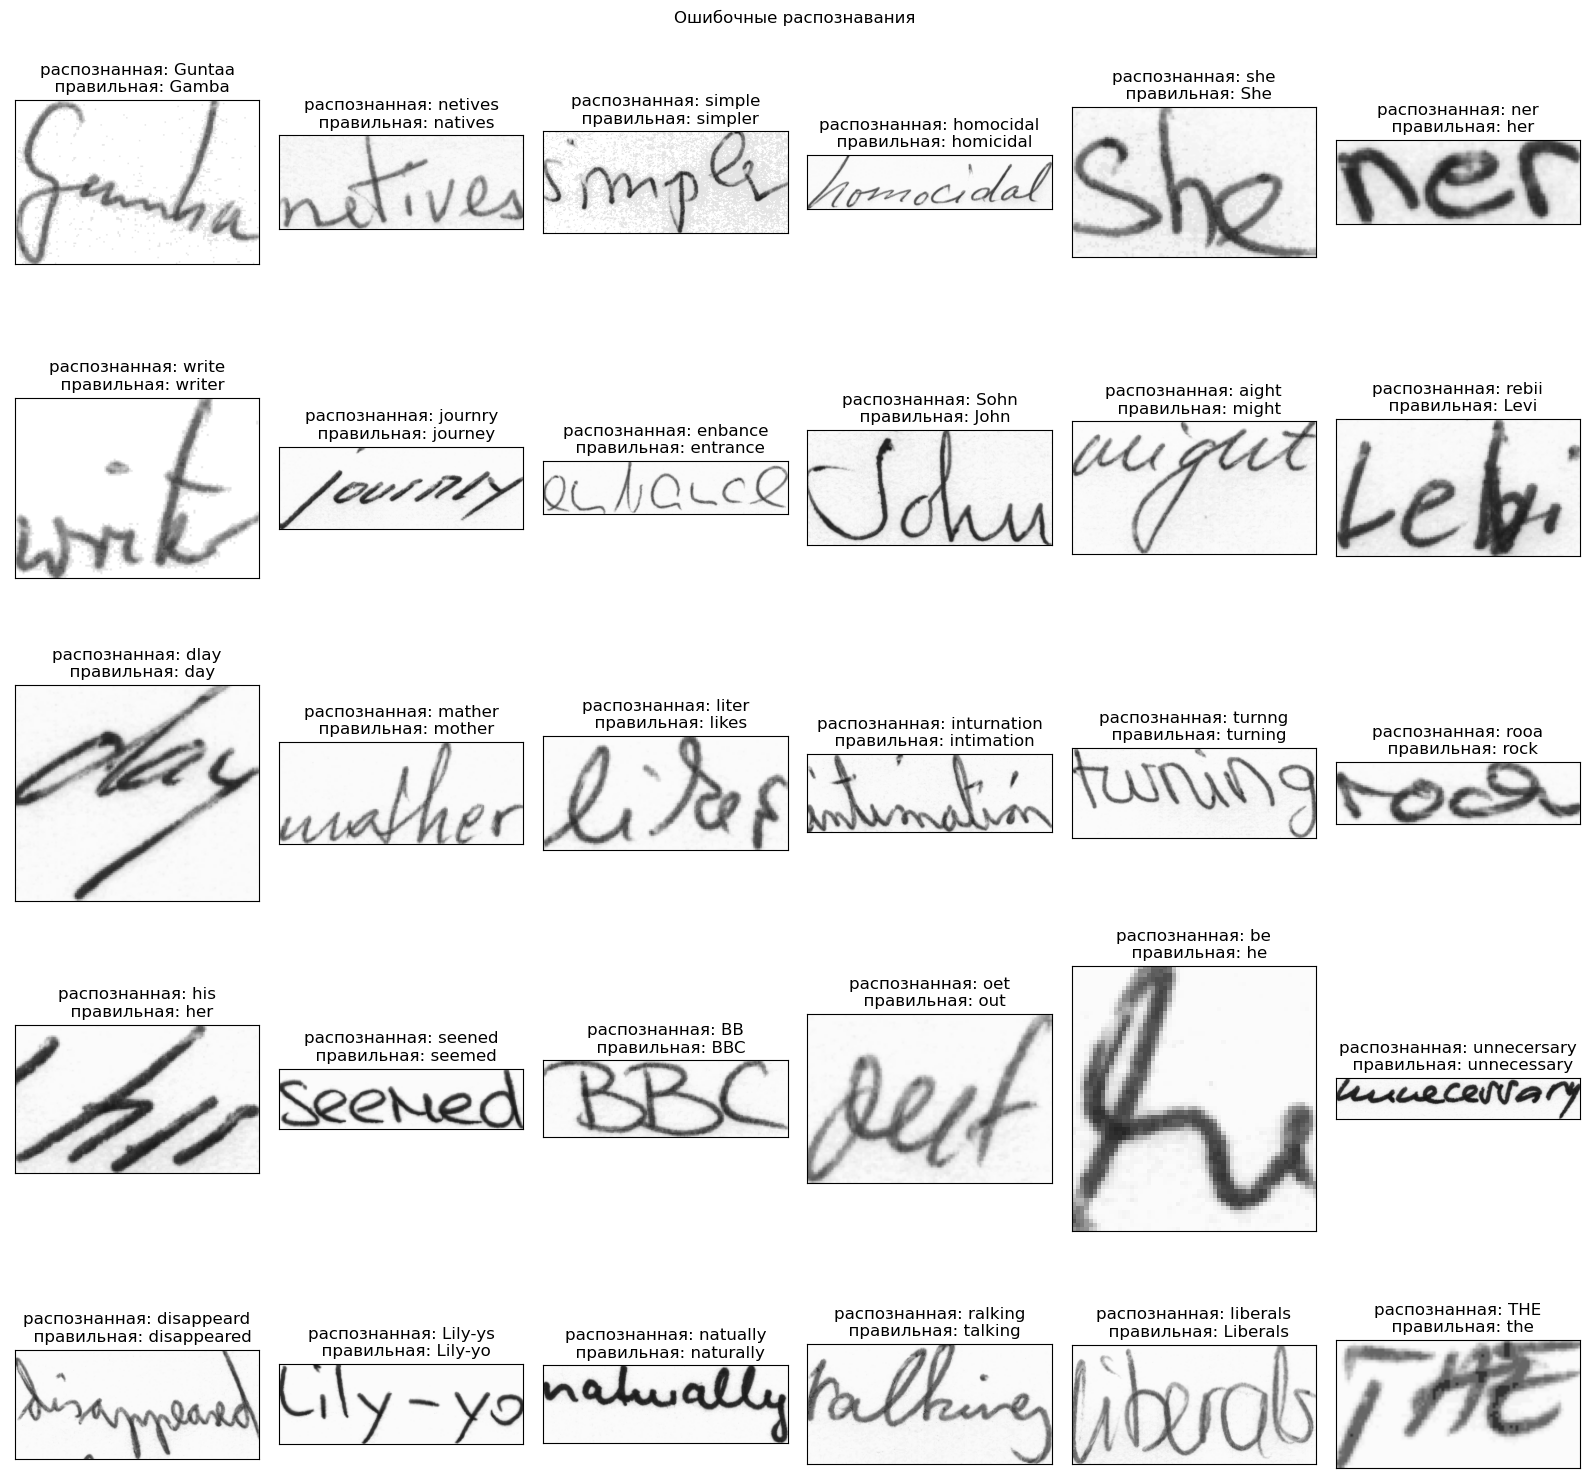

In [25]:
_, mistakes = detailed_stat(pred_file, target_file)

test_dir = '/home/astrashnov/data/iam_data/test_words'
some_mistakes = random.choices(mistakes, k = 30)

plt.figure(figsize=(16, 16))
for i, (pred, target, name) in enumerate(some_mistakes):
    image = cv2.imread(os.path.join(test_dir, name))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.subplot(5, 6, i + 1)
    plt.imshow(image)
    plt.title(f'распознанная: {pred}\n  правильная: {target}')
    plt.xticks([], [])
    plt.yticks([], [])
plt.suptitle('Ошибочные распознавания')
plt.tight_layout()
plt.show()

### Модель, предобученная на MJSynth + SynthText (словарь MC):

Получим предсказания обученной модели, а также правильные метки:

In [26]:
pred_file = '/home/astrashnov/vedastr/workdir/predictions_cstr_MJSST+original_MC.txt'
target_file = '/home/astrashnov/data/iam_data/rec_test.txt'

##### Качество модели:

In [27]:
general_stat(pred_file, target_file, alphabet="abcdefghijklmnopqrstuvwxyz")

Accuracy (MC, all words): 0.8761904761904762
Accuracy (MC, long words): 0.6530944625407166
Accuracy (MC, short words): 0.8843875291724014
Normalized edit distance 1 (MC, all words): 0.03863187237646115
Normalized edit distance 1 (MC, long words): 0.0570400419341788
Normalized edit distance 1 (MC, short words): 0.037955514521848026
Normalized edit distance 2 (MC, all words): 0.043096026921973236
Normalized edit distance 2 (MC, long words): 0.057666316263703256
Normalized edit distance 2 (MC, short words): 0.04171011470281543


Посмотрим на некоторые неправильно распознанные изображения:

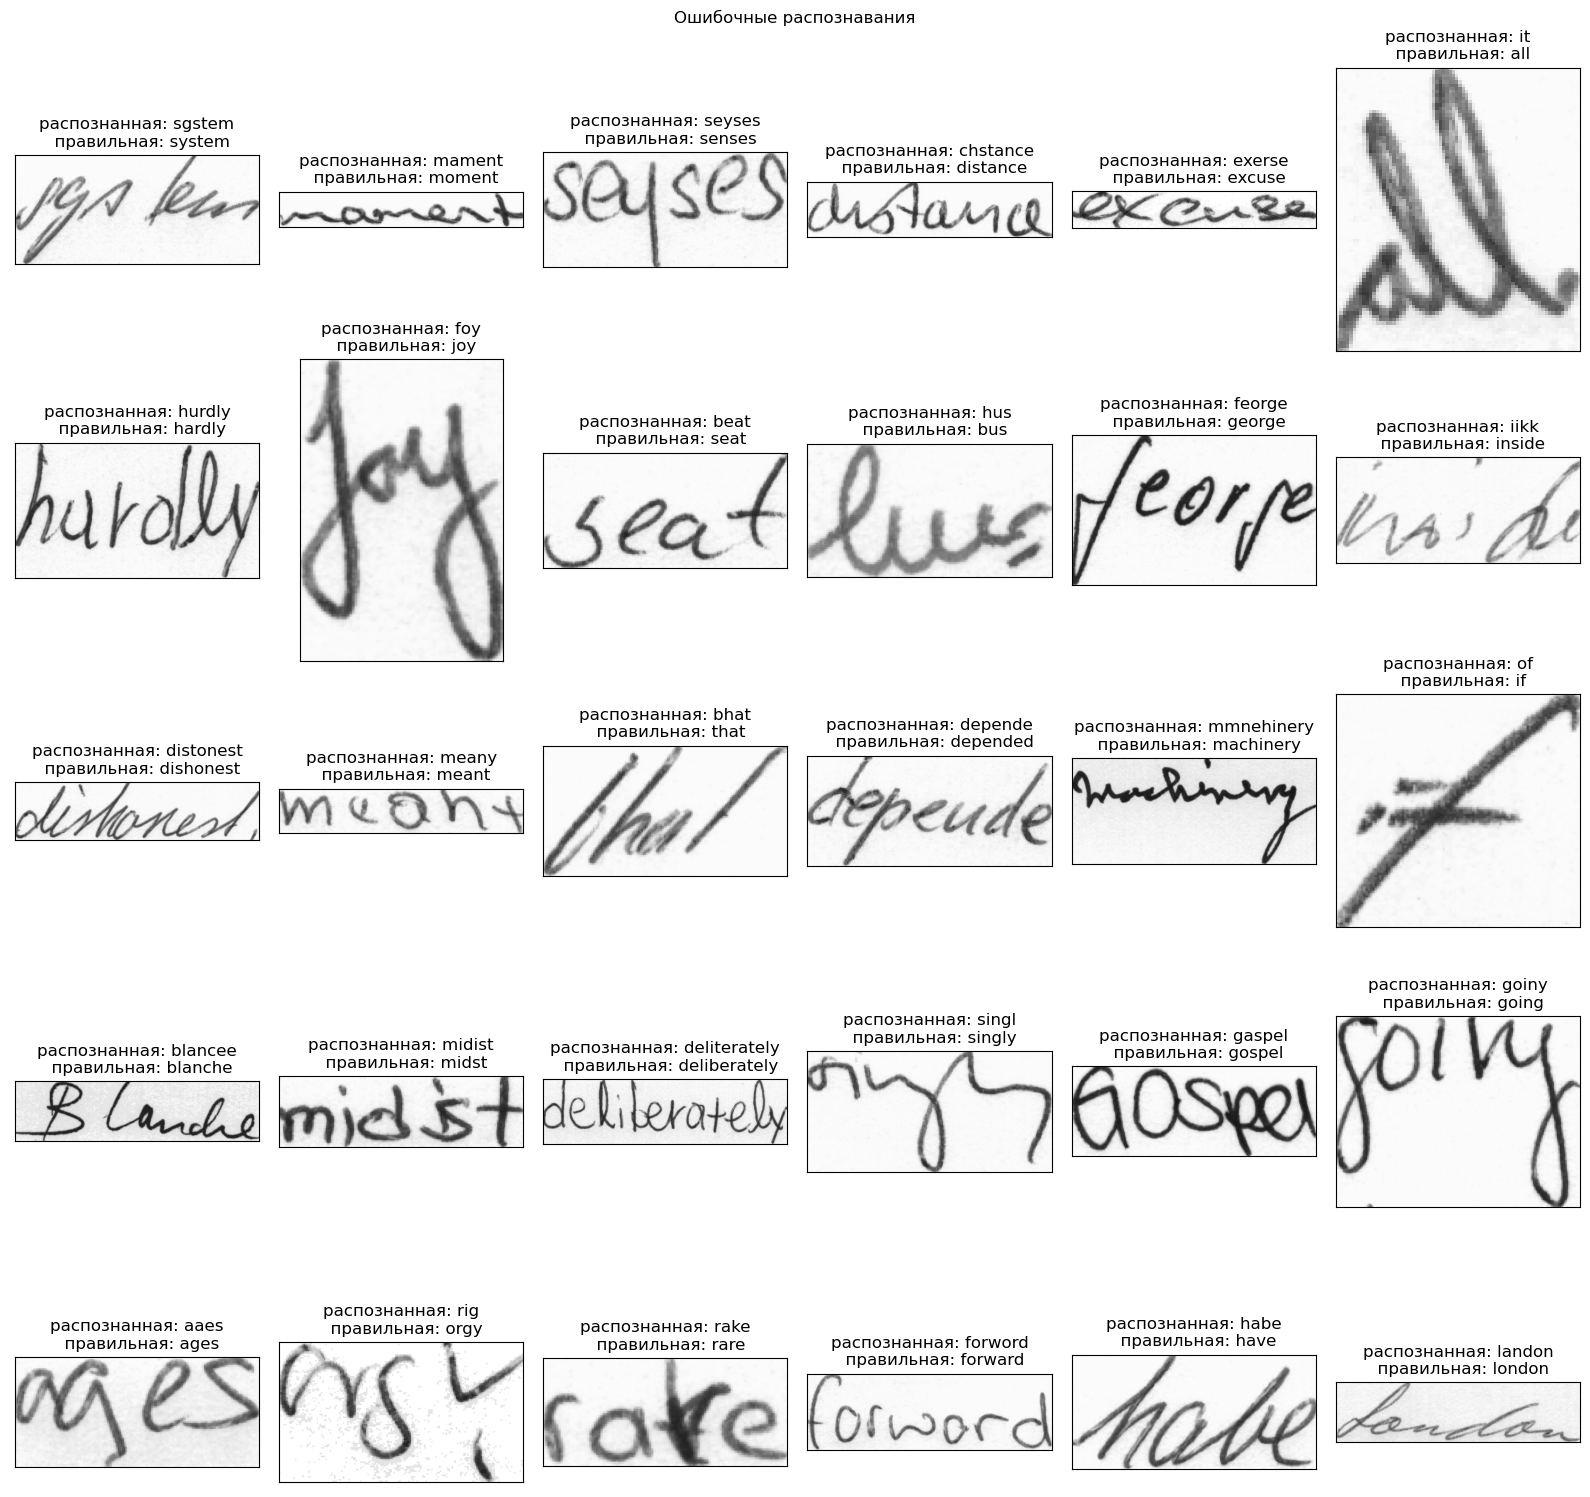

In [28]:
_, mistakes = detailed_stat(pred_file, target_file, alphabet="abcdefghijklmnopqrstuvwxyz")

test_dir = '/home/astrashnov/data/iam_data/test_words'
some_mistakes = random.choices(mistakes, k = 30)

plt.figure(figsize=(16, 16))
for i, (pred, target, name) in enumerate(some_mistakes):
    image = cv2.imread(os.path.join(test_dir, name))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.subplot(5, 6, i + 1)
    plt.imshow(image)
    plt.title(f'распознанная: {pred}\n  правильная: {target}')
    plt.xticks([], [])
    plt.yticks([], [])
plt.suptitle('Ошибочные распознавания')
plt.tight_layout()
plt.show()